In [1]:
# basics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import random
from functools import partial
import networkx as nx
# penny
import pennylane as qml
from pennylane.transforms import *
from pennylane.math import fidelity_statevector as fidelity_penny
# qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Gate
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_circuit_layout, circuit_drawer
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import state_fidelity as fidelity_qiskit
from math import pi
import copy

In [2]:
from transpilation_util import *

In [3]:
from penny_to_graph_2 import Penny_to_Graph


In [6]:
[ds] = qml.data.load("ketgpt")

In [ ]:
random.seed(42)
# seed = random.randint(0,1000)
seed = 0
@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

print(summary_penny(circuit))

               0
num_qubit     13
num_gate     205
num_1q_gate  116
num_2q_gate   25
unitary       64
depth         72
None


In [9]:
my_pg = Penny_to_Graph(circuit)

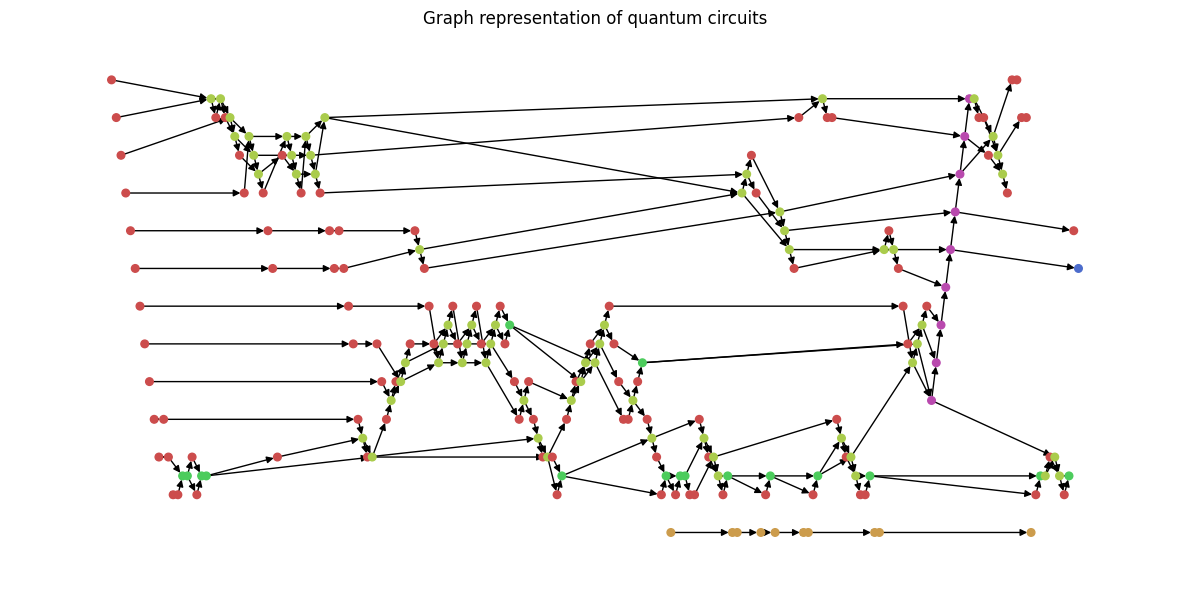

In [10]:
my_pg.show_graph()

In [11]:
summary_penny(circuit)

               0
num_qubit     13
num_gate     205
num_1q_gate  116
num_2q_gate   25
unitary       64
depth         72


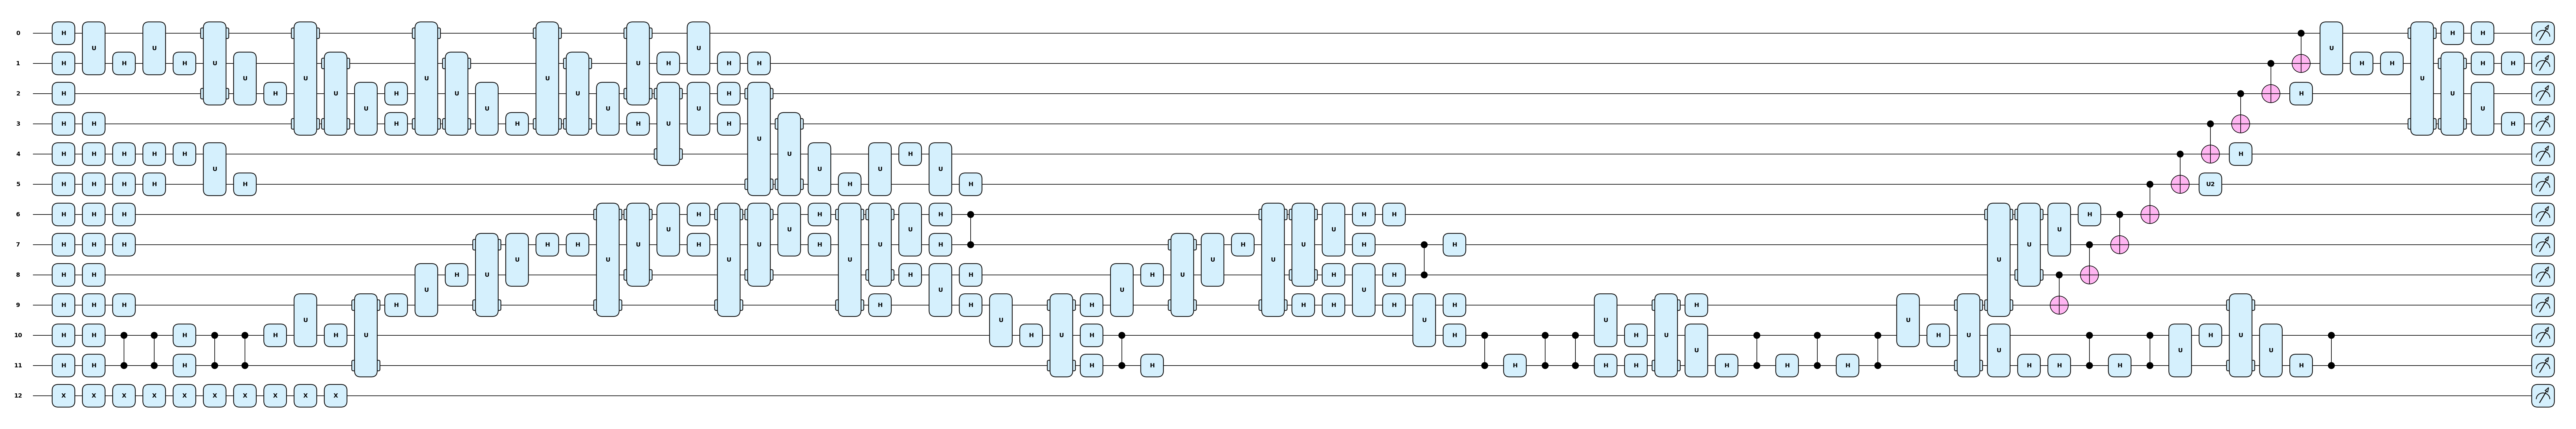

In [119]:
fig, axs = qml.draw_mpl(circuit, style='pennylane')()
plt.show()

In [12]:
circuit_info  = extract_info_from_qnode(circuit)
circuit_info[:5]

[{'name': 'Hadamard', 'wires': [0], 'params': []},
 {'name': 'Hadamard', 'wires': [1], 'params': []},
 {'name': 'Hadamard', 'wires': [2], 'params': []},
 {'name': 'Hadamard', 'wires': [3], 'params': []},
 {'name': 'Hadamard', 'wires': [4], 'params': []}]

In [440]:
g_name = []
for g in circuit_info:
    g_name.append(g['name'])
set(g_name)

{'CNOT', 'CZ', 'Hadamard', 'PauliX', 'QubitUnitary', 'U2'}

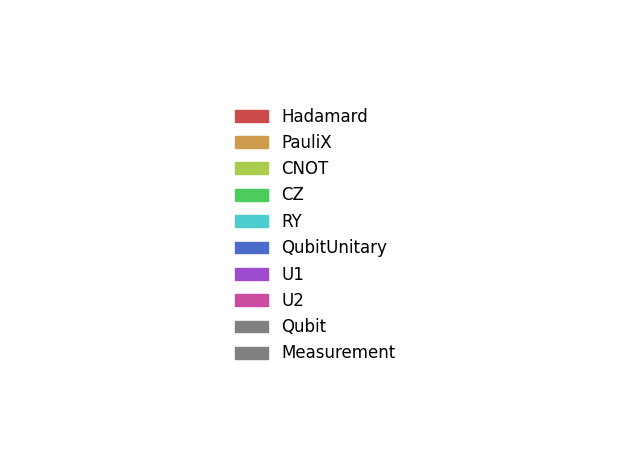

In [140]:
gate_colors = {
    'Hadamard': '#cc4c4c',
    'PauliX': '#cc9c4c',
    'CNOT': '#aacc4c',
    'CZ': '#4ccc5c',
    'RY': '#4ccccc',
    'QubitUnitary': '#4c6ccc',
    'U1': '#9c4ccc',
    'U2': '#cc4ca2'
}

# Add qubit and measurement colors
extra_colors = {
    'Qubit': '#808080',
    'Measurement': "#808080"
}

# Combine all patches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in {**gate_colors, **extra_colors}.items()]

# Create a standalone legend figure
fig, ax = plt.subplots()
ax.axis('off')
legend = ax.legend(handles=legend_patches, loc='center', fontsize=12, frameon=False)
plt.tight_layout()
plt.show()

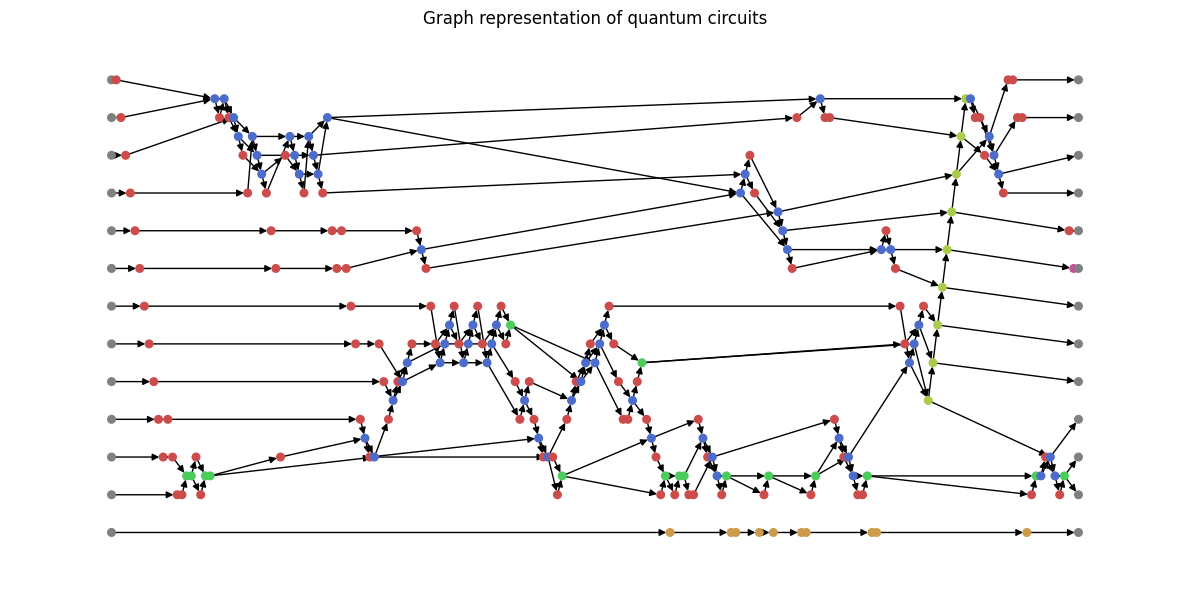

In [142]:
def circuit_to_graph(circuit_info):
    gate_colors = {
        'Hadamard': '#cc4c4c',
        'PauliX': '#cc9c4c',
        'CNOT': '#aacc4c',
        'CZ': '#4ccc5c',
        'RY': '#4ccccc',
        'QubitUnitary': '#4c6ccc',
        'U1': '#9c4ccc',
        'U2': '#cc4ca2'
    }

    G = nx.DiGraph()
    num_qubits = max(w for gate in circuit_info for w in gate['wires']) + 1
    qubit_timelines = {q: [] for q in range(num_qubits)}

    for q in range(num_qubits):
        G.add_node(f"q[{q}]", type='qubit')

    for i, gate in enumerate(circuit_info):
        gate_id = f"{gate['name']}_{i}"
        G.add_node(gate_id, type='gate', label=gate['name'], params=gate['params'], wires=gate['wires'])
        for wire in gate['wires']:
            qubit_timelines[wire].append(gate_id)

    for q, timeline in qubit_timelines.items():
        if timeline:
            G.add_edge(f"q[{q}]", timeline[0])
            for i in range(len(timeline) - 1):
                G.add_edge(timeline[i], timeline[i + 1])

    pos = {}
    x_spacing = 0.6
    y_spacing = 0.8

    for q in range(num_qubits):
        pos[f"q[{q}]"] = (0, -q * y_spacing)

    for i, gate in enumerate(circuit_info):
        gate_id = f"{gate['name']}_{i}"
        avg_y = -sum(gate['wires']) / len(gate['wires']) * y_spacing
        pos[gate_id] = ((i + 1) * x_spacing, avg_y)

    max_gate_x = (len(circuit_info) + 1) * x_spacing
    for q, timeline in qubit_timelines.items():
        meas_id = f"Measure[{q}]"
        G.add_node(meas_id, type='measure')
        if timeline:
            G.add_edge(timeline[-1], meas_id)
        else:
            G.add_edge(f"q[{q}]", meas_id)
        pos[meas_id] = (max_gate_x, -q * y_spacing)

    node_colors = []
    for node in G.nodes:
        node_type = G.nodes[node]['type']
        if node_type == 'gate':
            node_colors.append(gate_colors.get(G.nodes[node]['label'], 'lightgray'))
        else:
            node_colors.append('#808080')  # qubit or measure

    return G, pos, node_colors

# Build full graph
G_full, pos_full, node_colors_full = circuit_to_graph(circuit_info)

# Visualize full graph
fig, ax = plt.subplots(figsize=(12, 6))
nx.draw(G_full, pos_full, with_labels=False, node_color=node_colors_full, node_size=30, font_size=8, ax=ax)
plt.title("Graph representation of quantum circuits")
plt.tight_layout()
plt.show()

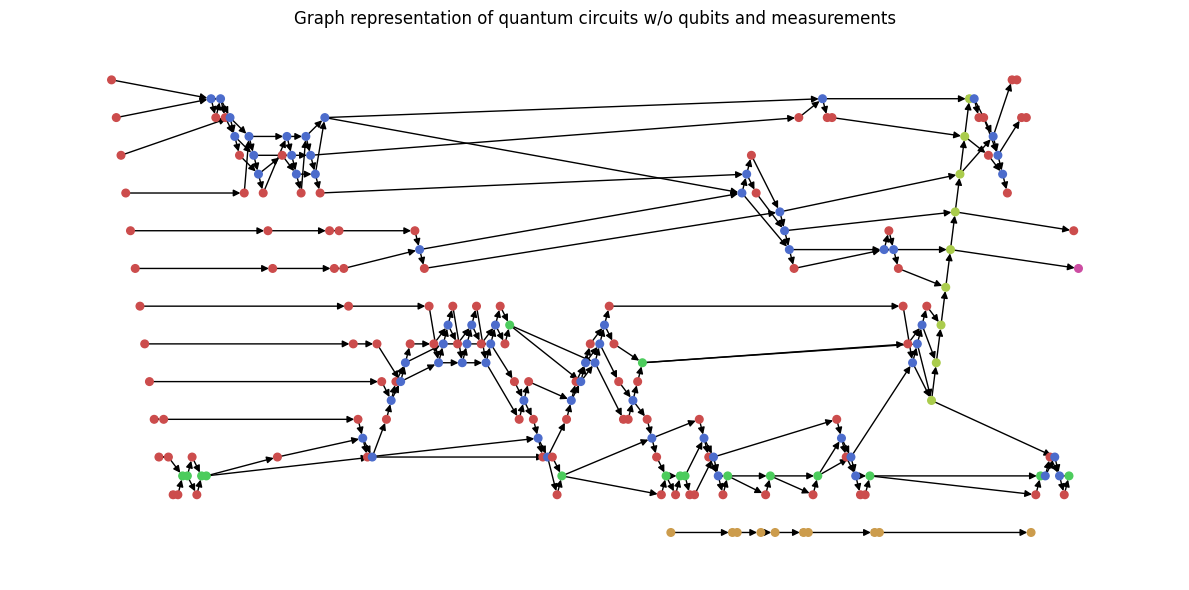

In [143]:
# remove redundant nodes - quibt and measurement 
def remove_nodes(G):
    # Step 1: Remove qubit and measurement nodes
    nodes_to_remove = [n for n, attr in G.nodes(data=True) if attr.get('type') in ('qubit', 'measure')]
    G_clean = G.copy()
    G_clean.remove_nodes_from(nodes_to_remove)

    # Step 2: Filter layout
    pos_clean = {n: pos_full[n] for n in G_clean.nodes if n in pos_full}

    # Step 3: Filter node_colors to match G_clean
    node_colors_clean = [node_colors_full[list(G.nodes).index(n)] for n in G_clean.nodes]
    return G_clean, pos_clean, node_colors_clean

G, pos, node_colors = remove_nodes(G_full)

fig, ax = plt.subplots(figsize=(12, 6))
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=30, font_size=8, ax=ax)
plt.title("Graph representation of quantum circuits w/o qubits and measurements")
plt.tight_layout()
plt.show()


In [148]:
def color_generator(n):
    random.seed(42)
    colors = []
    for _ in range(n):
        hex_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        colors.append(hex_color)
    return colors

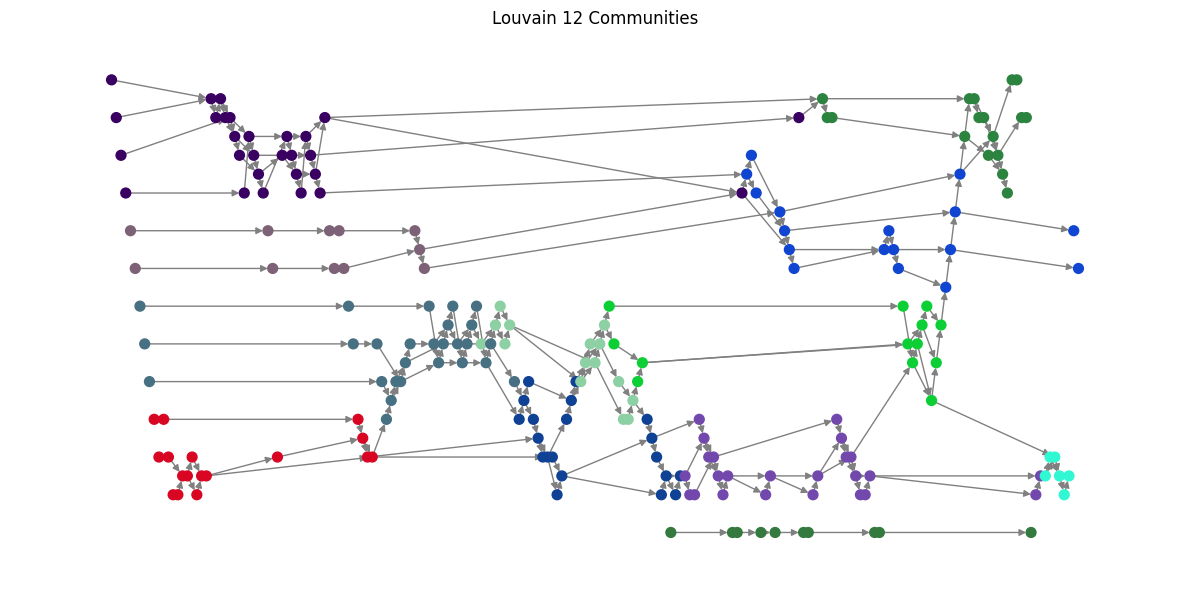

In [154]:
import community as community_louvain

# Step 1: Apply Louvain method
partition = community_louvain.best_partition(G.to_undirected())

# Step 2: Assign colors to communities
# palette = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6']
palette = color_generator(20)
node_colors = [palette[partition[node] % len(palette)] for node in G.nodes]

# Step 3: Draw the graph
fig, ax = plt.subplots(figsize=(12, 6))
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=50, font_size=8, edge_color='gray', ax=ax)
plt.title(f"Louvain {len(np.unique(node_colors))} Communities")
plt.tight_layout()
plt.show()

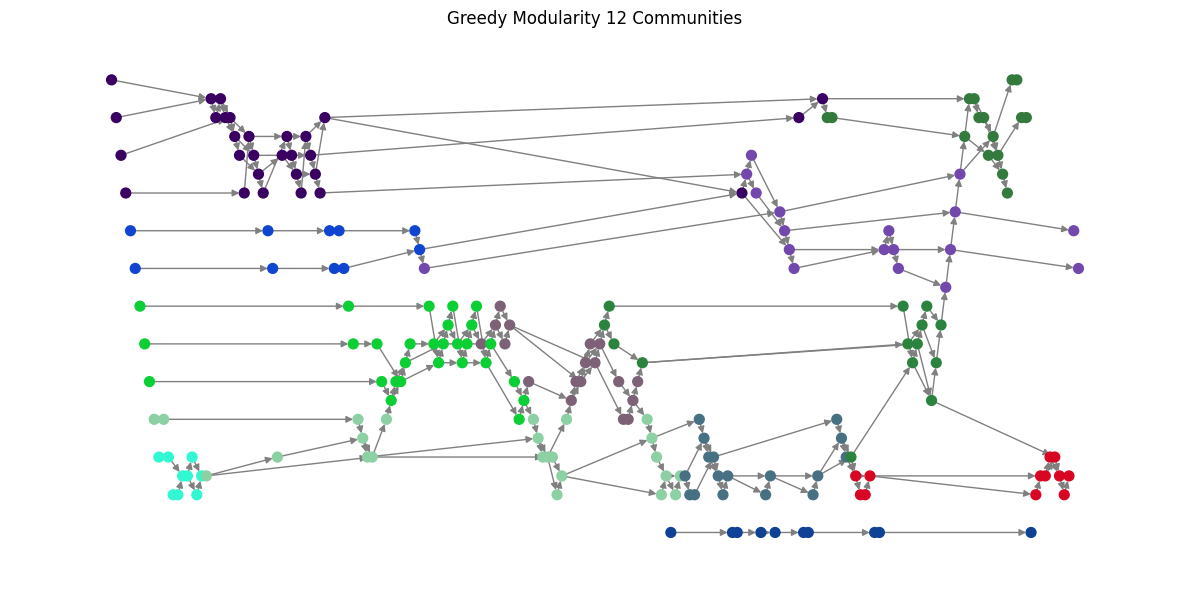

In [ ]:
# Step 1: Apply Greedy Modularity
communities = list(nx.community.greedy_modularity_communities(G.to_undirected()))

# Step 2: Assign colors to communities
node_color_map = {}
for i, community in enumerate(communities):
    color = palette[i % len(palette)]
    for node in community:
        node_color_map[node] = color

# Step 3: Build node_colors list
node_colors = [node_color_map.get(node, '#999999') for node in G.nodes]

# Step 4: Draw the graph
fig, ax = plt.subplots(figsize=(12, 6))
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=50, font_size=8, edge_color='gray', ax=ax)
plt.title(f"Greedy Modularity {len(communities)} Communities")
plt.tight_layout()
plt.show()

In [164]:
# Assign community index to each node in G
for i, community in enumerate(communities):
    for node in community:
        G.nodes[node]['community'] = i

In [243]:
[n for n in G.nodes if G.nodes[n].get('community') == 10][:5]

['PauliX_118', 'PauliX_131', 'PauliX_132', 'PauliX_137', 'PauliX_140']

In [172]:
G.nodes['QubitUnitary_90']

{'type': 'gate',
 'label': 'QubitUnitary',
 'params': [[[(1+0j), 0j, 0j, 0j],
   [0j, (1+0j), 0j, 0j],
   [0j, 0j, (1+0j), 0j],
   [0j, 0j, 0j, (6.123233995736766e-17-1j)]]],
 'wires': [10, 9],
 'community': 2}

In [ ]:
def get_subcircuit(G, ds, communities, seed=0):
    # idx
    subcircuit_idx_arr = []
    for i in range(len(communities)):
        temp_gate = [n for n in G.nodes if G.nodes[n].get('community') == i]
        temp_com_label = [int(g.split('_')[1]) for g in temp_gate]
        subcircuit_idx_arr.append(temp_com_label)
    # gate list
    subcircuit_gate_arr = []
    for i in range(len(communities)):
        subcircuit_gate_arr.append([ds.circuits[seed][j] for j in subcircuit_idx_arr[i]])
    return subcircuit_gate_arr

In [271]:
def wire_range(gate_list):
    wires = []
    for gate in gate_list:
        if hasattr(gate, 'wires'):
            wires.extend(gate.wires)
        elif hasattr(gate, 'wire'):
            wires.append(gate.wire)
        elif isinstance(gate, tuple) or isinstance(gate, list):
            # fallback for custom gate representations
            for item in gate:
                if hasattr(item, 'wires'):
                    wires.extend(item.wires)
                elif hasattr(item, 'wire'):
                    wires.append(item.wire)
        elif hasattr(gate, '__str__'):
            # fallback for string-like gates like H(0)
            import re
            match = re.findall(r'\((\d+)\)', str(gate))
            wires.extend([int(m) for m in match])
    return [min(wires), max(wires)]

In [280]:
test = get_subcircuit(G, ds)[1]
wire_range(test)

[6, 9]

In [281]:
test_U = get_subcircuit(G, ds)[0][4]
test_U

QubitUnitary(array([[1.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 1.000000e+00+0.j, 0.000000e+00+0.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 0.000000e+00+0.j, 1.000000e+00+0.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
        6.123234e-17-1.j]]), wires=[1, 0])

In [323]:
@qml.qnode(qml.device('default.qubit'))
def subcircuit(): # 0 to 99
    for j in get_subcircuit(G, ds)[2]:
        qml.apply(j)
    return qml.state()

print(summary_penny(subcircuit))

   num_qubit  num_gate  num_1q_gate  num_2q_gate  depth
0          3        24           15            9     16
None


In [327]:
initial_matrix = np.diag(np.ones(np.power(2,3)))
initial_matrix[1]

array([0., 1., 0., 0., 0., 0., 0., 0.])

In [332]:
@qml.qnode(qml.device('default.qubit'))
def subcircuit(): # 0 to 99
    qml.PauliX(1)
    for j in get_subcircuit(G, ds)[2]:
        qml.apply(j)
    return qml.state()

print(summary_penny(subcircuit))

   num_qubit  num_gate  num_1q_gate  num_2q_gate  depth
0          4        25           16            9     16
None


In [357]:
test_gate_arr = get_subcircuit(G, ds)[2]
[w_min, w_max] = wire_range(test_gate_arr)
num_eq = w_max - w_min + 1
wires = np.arange(w_min, w_max+1,1)
initial_matrix = np.diag(np.ones(np.power(2,num_eq)))
# wire_map = generate_wire_map(wires)
# shifted_ops = [qml.map_wires(op, wire_map) for op in test_gate_arr]

# effective unitary
dev = qml.device('default.qubit', wires=wires)
@qml.qnode(dev)
def subcircuit_syntehsis(idx):
    qml.StatePrep(initial_matrix[idx], wires=wires)
    for j in test_gate_arr:
        qml.apply(j)
    return qml.state()

In [358]:
subcircuit_syntehsis(2)

array([ 3.53553391e-01+0.00000000e+00j, -3.53553391e-01+0.00000000e+00j,
        3.53553391e-01+0.00000000e+00j,  3.53553391e-01+0.00000000e+00j,
       -2.77555756e-17+3.53553391e-01j,  3.53553391e-01+5.55111512e-17j,
       -2.77555756e-17+3.53553391e-01j, -3.53553391e-01-5.55111512e-17j])

In [ ]:
def subcircuit_syntehsis(subcircuit):
    """takes a subcircuit as input and returns an effective unitary"""
    [w_min, w_max] = wire_range(subcircuit)
    wires = np.arange(w_min, w_max+1,1)
    num_eq = w_max - w_min + 1
    initial_matrix = np.diag(np.ones(np.power(2,num_eq)))

    # effective unitary
    dev = qml.device('default.qubit', wires=wires)
    @qml.qnode(dev)
    def internal_circuit(idx):
        qml.StatePrep(initial_matrix[idx], wires=wires)
        for j in subcircuit:
            qml.apply(j)
        return qml.state()
    
    effective_u = []
    for idx in range(np.power(2,num_eq)):
        effective_u.append(internal_circuit(idx))
    effective_u = np.stack(effective_u, axis=1)
    
    return effective_u

In [360]:
subcircuit_syntehsis(test_gate_arr).shape

(8, 8)

In [365]:
# subcircut synthesis summary

def wire_range(gate_list):
    wires = []
    for gate in gate_list:
        if hasattr(gate, 'wires'):
            wires.extend(gate.wires)
        elif hasattr(gate, 'wire'):
            wires.append(gate.wire)
        elif isinstance(gate, tuple) or isinstance(gate, list):
            # fallback for custom gate representations
            for item in gate:
                if hasattr(item, 'wires'):
                    wires.extend(item.wires)
                elif hasattr(item, 'wire'):
                    wires.append(item.wire)
        elif hasattr(gate, '__str__'):
            # fallback for string-like gates like H(0)
            import re
            match = re.findall(r'\((\d+)\)', str(gate))
            wires.extend([int(m) for m in match])
    return [min(wires), max(wires)]

def calculate_effective_u(subcircuit):
    """takes a subcircuit as input and returns an effective unitary"""
    [w_min, w_max] = wire_range(subcircuit)
    wires = np.arange(w_min, w_max+1,1)
    num_eq = w_max - w_min + 1
    initial_matrix = np.diag(np.ones(np.power(2,num_eq)))

    # effective unitary
    dev = qml.device('default.qubit', wires=wires)
    @qml.qnode(dev)
    def internal_circuit(idx):
        qml.StatePrep(initial_matrix[idx], wires=wires)
        for j in subcircuit:
            qml.apply(j)
        return qml.state()
    
    effective_u = []
    for idx in range(np.power(2,num_eq)):
        effective_u.append(internal_circuit(idx))
    effective_u = np.stack(effective_u, axis=1)
    
    return effective_u, wires

def subcircuit_syntehsis(G, ds, seed=0):
    num_community = len(communities)
    # idx
    subcircuit_idx_arr = []
    for i in range(num_community):
        temp_gate = [n for n in G.nodes if G.nodes[n].get('community') == i]
        temp_com_label = [int(g.split('_')[1]) for g in temp_gate]
        subcircuit_idx_arr.append(temp_com_label)

    # gate list
    subcircuit_gate_arr = []
    for i in range(num_community):
        subcircuit_gate_arr.append([ds.circuits[seed][j] for j in subcircuit_idx_arr[i]])

    u_arr = []
    wire_arr = []
    for i in range(num_community):
        u_temp, w_temp = calculate_effective_u(subcircuit_gate_arr[i])
        u_arr.append(u_temp)
        wire_arr.append(w_temp)

    effective_u_dic = {}
    effective_u_dic['u'] = u_arr
    effective_u_dic['wires'] = wire_arr

    return effective_u_dic

In [367]:
effective_u_dic = subcircuit_syntehsis(G, ds, seed=0)

In [400]:
dev = qml.device('default.qubit')

# @partial(decompose, gate_set={qml.CZ, qml.CNOT, qml.RZ, qml.RY, qml.RX, qml.SX, qml.PauliX})
@qml.qnode(dev)
def combine_u():
    for i in range(len(effective_u_dic['u'])):
        qml.QubitUnitary(effective_u_dic['u'][i], wires=effective_u_dic['wires'][i])
    return qml.state()

combine_u()

array([-0.00209275+0.0086724j ,  0.        +0.j        ,
        0.00449339+0.01186388j, ...,  0.        +0.j        ,
        0.01055508-0.00034076j,  0.        +0.j        ])

In [403]:
dev = qml.device('default.qubit')

# @partial(decompose, gate_set={qml.CZ, qml.CNOT, qml.RZ, qml.RY, qml.RX, qml.SX, qml.PauliX})
@qml.qnode(dev)
def decompose_combined_u():
    for i in range(len(effective_u_dic['u'])):
        qml.QubitUnitary(effective_u_dic['u'][i], wires=effective_u_dic['wires'][i])
    return qml.state()

print(summary_penny(decompose_combined_u))

              0
num_qubit    13
num_gate     12
num_1q_gate   1
num_2q_gate   0
unitary      12
depth         7
None


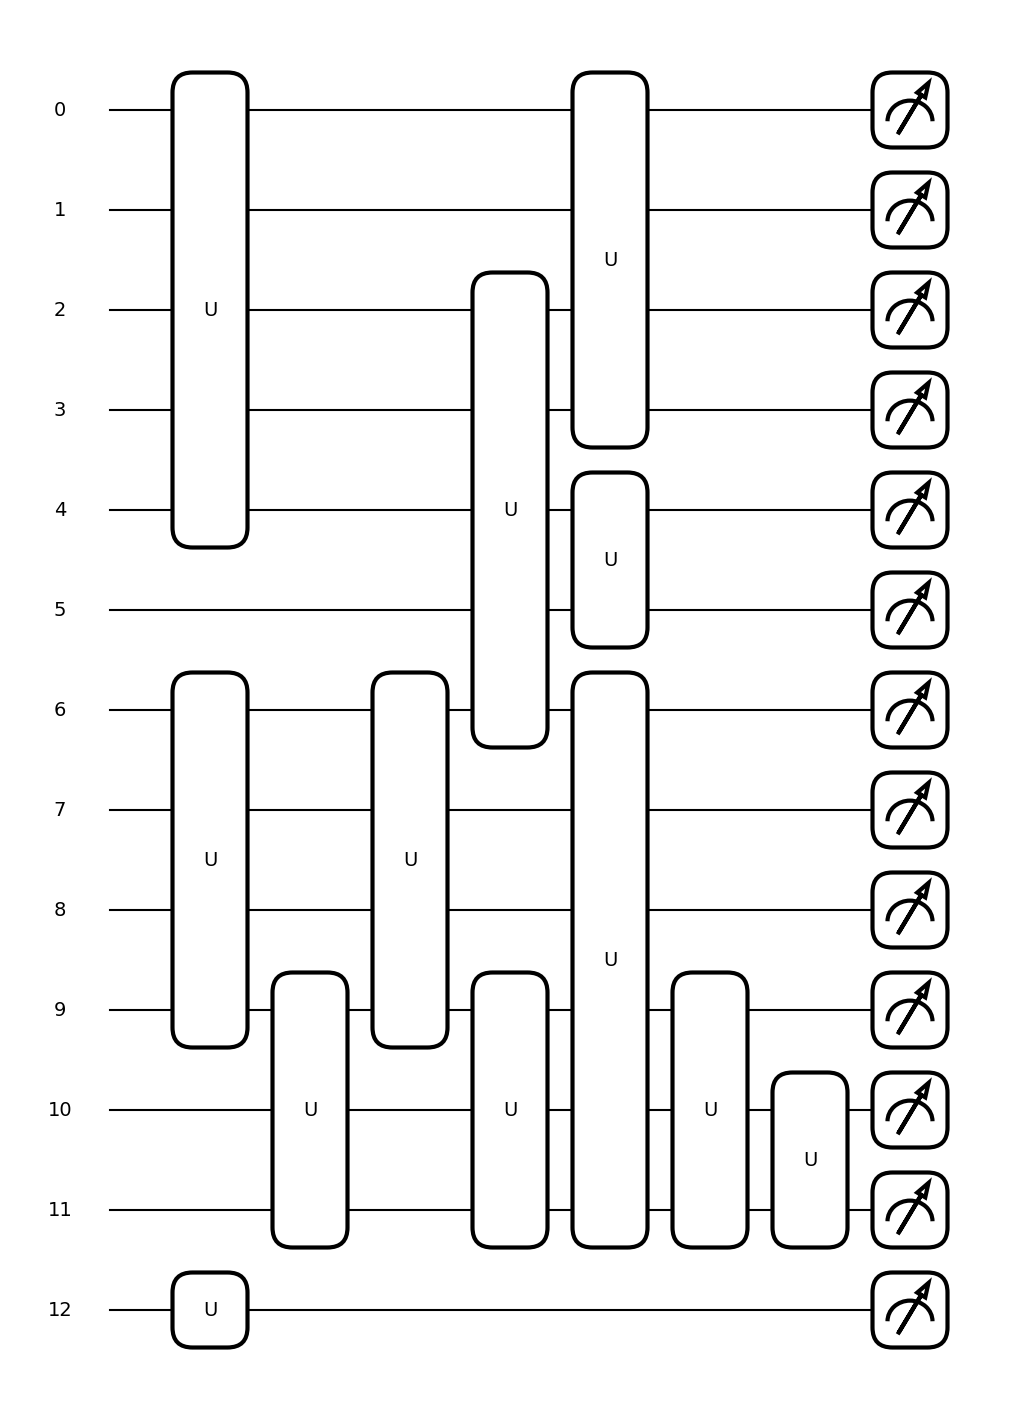

In [391]:
qml.draw_mpl(decompose_combined_u)()
plt.show()

In [428]:
dev = qml.device('default.qubit')
@compile
@partial(decompose, gate_set={qml.CZ, qml.CNOT, qml.RZ, qml.RY, qml.RX, qml.SX, qml.PauliX})
@qml.qnode(dev)
def decompose_combined_u():
    for i in range(len(effective_u_dic['u'])):
        qml.QubitUnitary(effective_u_dic['u'][i], wires=effective_u_dic['wires'][i])
    return qml.state()

print(summary_penny(decompose_combined_u))

                0
num_qubit      13
num_gate     9770
num_1q_gate  6457
num_2q_gate  3313
unitary         0
depth        5601
None


Penny's

In [430]:
dev = qml.device('default.qubit')

@compile
# @partial(decompose, gate_set={qml.CZ, qml.CNOT, qml.RZ, qml.RY, qml.RX, qml.SX, qml.PauliX})
@qml.qnode(dev)
def circuit(): # 0 to 99
    for op in ds.circuits[0]:
        qml.apply(op)
    return qml.state()

print(summary_penny(circuit))

               0
num_qubit     12
num_gate     147
num_1q_gate   64
num_2q_gate   19
unitary       64
depth         60
None


In [431]:
dev = qml.device('default.qubit')
@partial(decompose, gate_set={qml.CZ, qml.CNOT, qml.RZ, qml.RY, qml.RX, qml.SX, qml.PauliX})
@compile
@qml.qnode(dev)
def circuit(): # 0 to 99
    for op in ds.circuits[0]:
        qml.apply(op)
    return qml.state()

print(summary_penny(circuit))

                0
num_qubit      12
num_gate     1365
num_1q_gate  1154
num_2q_gate   211
unitary         0
depth         422
None


In [433]:
dev = qml.device('default.qubit')
@compile
@partial(decompose, gate_set={qml.CZ, qml.CNOT, qml.RZ, qml.RY, qml.RX, qml.SX, qml.PauliX})
# @compile
@qml.qnode(dev)
def circuit(): # 0 to 99
    for op in ds.circuits[0]:
        qml.apply(op)
    return qml.state()

print(summary_penny(circuit))

                0
num_qubit      12
num_gate     1272
num_1q_gate  1061
num_2q_gate   211
unitary         0
depth         398
None


In [434]:
dev = qml.device('default.qubit')
# @compile
@partial(decompose, gate_set={qml.CZ, qml.CNOT, qml.RZ, qml.RY, qml.RX, qml.SX, qml.PauliX})
@compile
@qml.qnode(dev)
def circuit(): # 0 to 99
    for op in ds.circuits[0]:
        qml.apply(op)
    return qml.state()

print(summary_penny(circuit))

                0
num_qubit      12
num_gate     1365
num_1q_gate  1154
num_2q_gate   211
unitary         0
depth         422
None
